In [35]:
import os
import sys
import textwrap
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN, BPR
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from concurrent.futures import ThreadPoolExecutor
from itertools import product
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from collections import defaultdict

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE=False

System version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Cornac version: 2.3.0


Exploring the Data

In [36]:
feedback = cornac.datasets.netflix.load_feedback(fmt='UIR', variant='small')

In [37]:
print('Type of dataset:', type(feedback))
print('Entry example:', feedback[0])

Type of dataset: <class 'list'>
Entry example: ('2567280', '2', 3.0)


In [38]:
df = pd.DataFrame(feedback, columns=['userid', 'itemid', 'rating'])

<Axes: >

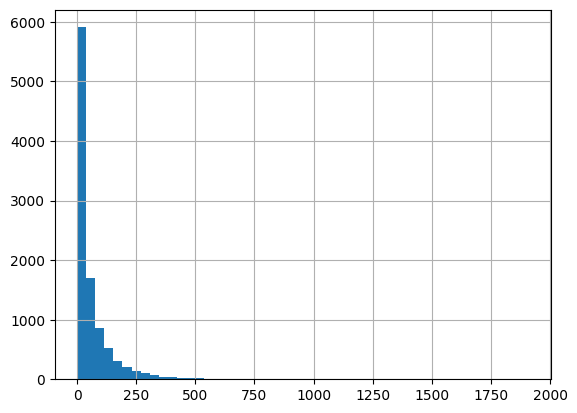

In [39]:
# Distribution of ratings by user
df.groupby('userid')['rating'].count().hist(bins=50)

<Axes: >

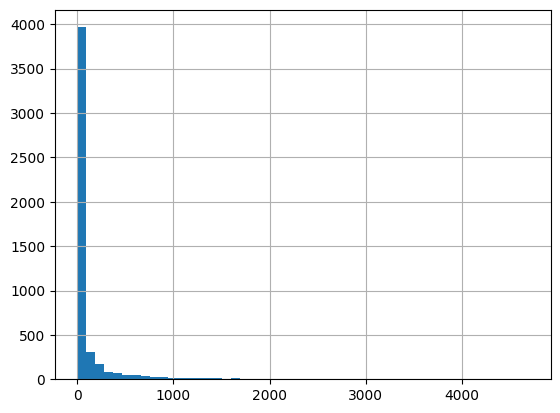

In [40]:
# Distribution of ratings by item
df.groupby('itemid')['rating'].count().hist(bins=50)

In [41]:
# Data sparsity, a mesure of how much data we do not observe
n_users = df.userid.nunique()
n_movies = df.itemid.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_movies
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_movies}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"Sparsity: {sparsity * 100.0:.2f}%")

Number of users: 9992
Number of items: 4945
Number of available ratings: 607803
Number of all possible ratings: 49410440
----------------------------------------
Sparsity: 98.77%


User-Based

In [42]:
metrics = [cornac.metrics.RMSE(), 
           #cornac.metrics.MAE(),
           #cornac.metrics.Precision(k=10),
           #cornac.metrics.Recall(k=10),
           #cornac.metrics.NDCG(k=10)
]

In [43]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
experiment_uknn = cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=metrics,
)
experiment_uknn.run()


TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.8769 |    2.1521 |   6.3549
UserKNN-Cosine-MC  | 0.8773 |    2.0854 |   3.5230
UserKNN-Pearson    | 0.8773 |    2.1564 |   3.5368
UserKNN-Pearson-MC | 0.8773 |    2.1176 |   3.8320



Item-Based

In [44]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
experiment_iknn = cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=metrics
)
experiment_iknn.run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9225 |    0.5309 |   2.5584
ItemKNN-Pearson        | 0.9103 |    0.5996 |   2.5536
ItemKNN-Pearson-MC     | 0.9040 |    0.5778 |   2.5829
ItemKNN-AdjustedCosine | 0.8749 |    0.5187 |   5.4949



Making Recommendations

In [45]:
# Obtain all user ids and item ids from the interactions
user_ids = set()
item_ids = set()

# Each interaction is a tuple (user id, item id, rating)
for interaction in feedback:
    user_ids.add(interaction[0])  
    item_ids.add(interaction[1])  

user_ids = list(user_ids)
item_ids = list(item_ids)

In [46]:
item_interactions = {}

for interaction in feedback:
    item_id = interaction[1]
    item_interactions[item_id] = item_interactions.get(item_id, 0) + 1

# Sort items by interactions
sorted_items = sorted(item_interactions.items(), key=lambda x: x[1], reverse=True)

top_10_items = sorted_items[:10]
print(f"Top 10 items by number of interactions: {top_10_items}")

top_10_items = [sublist[0] for sublist in top_10_items]

Top 10 items by number of interactions: [('15124', 4692), ('15205', 4195), ('16377', 3910), ('6037', 3368), ('11064', 3283), ('7624', 3280), ('14367', 3280), ('4306', 3268), ('4996', 3249), ('12232', 3215)]


In [47]:
# Create dictionaries (user id: list of recommendations) for both methods, using the optimal models
uknn_recommendations = dict()
iknn_recommendations = dict()

for i in user_ids:
    if uknn_pearson.uid_map.get(i, -1) != -1:
        uknn_recommendations[i] = uknn_pearson.recommend(i, k = 15)  # Top 15 user-based recommendations
    else:
        uknn_recommendations[i] = top_10_items
    if iknn_adjusted.uid_map.get(i, -1) != -1:
        iknn_recommendations[i] = iknn_adjusted.recommend(i, k = 15)  # Top 15 item-based recommendations
    else:
        iknn_recommendations[i] = top_10_items

In [48]:
print('User-based recommendations:', uknn_recommendations)
print('Item-based recommendations:', iknn_recommendations)

User-based recommendations: {'621373': ['8546', '15602', '4202', '17615', '5753', '16921', '16028', '14626', '7103', '13590', '9026', '14486', '13467', '6621', '1227'], '2344621': ['10307', '14416', '3399', '1836', '8196', '14543', '17689', '16450', '3395', '539', '9358', '6276', '1537', '9755', '6124'], '36612': ['10307', '9755', '3897', '15602', '10728', '13312', '4875', '16693', '4202', '17615', '2807', '16028', '15038', '14406', '11816'], '1677939': ['8394', '3897', '15793', '4096', '8195', '1227', '4034', '4764', '16614', '15412', '11200', '4875', '11653', '6124', '13332'], '686176': ['13312', '4096', '6621', '2799', '3485', '1227', '17689', '3395', '539', '14543', '10443', '13264', '13717', '9302', '5365'], '971447': ['5575', '6628', '7353', '9403', '12544', '7089', '10075', '8195', '14914', '14136', '11200', '6124', '14097', '14406', '5753'], '1989286': ['14626', '8546', '3897', '16693', '5753', '16921', '11675', '8205', '15254', '8196', '14197', '6276', '14543', '16353', '12131

In [49]:
print(len(uknn_recommendations))
print(len(iknn_recommendations))

9992
9992


In [50]:
# Create dictionaries (user id: list of predictions) for both methods
uknn_predictions = dict()
iknn_predictions = dict()

def calculate_missing_scores(model, user_ids, item_ids, existing_pairs):
    scores = {}
    for user_id, item_id in product(user_ids, item_ids):
        if (user_id, item_id) not in existing_pairs:
            try:
                score = model.score(user_id, item_id)
                if score is not None:
                    scores[(user_id, item_id)] = score
            except:
                continue  # Ignores errors (not seen users/items)
    return scores

user_ids = df['userid'].unique()  
item_ids = df['itemid'].unique()
existing_pairs = set(zip(df['userid'], df['itemid']))

uknn_scores = calculate_missing_scores(uknn_pearson, user_ids, item_ids, existing_pairs)
iknn_scores = calculate_missing_scores(iknn_adjusted, user_ids, item_ids, existing_pairs)

# Convert to dataframe
df_uknn = pd.DataFrame([(k[0], k[1], v) for k, v in uknn_scores.items()], 
                       columns=['userid', 'itemid', 'uknn_score'])
df_iknn = pd.DataFrame([(k[0], k[1], v) for k, v in iknn_scores.items()], 
                       columns=['userid', 'itemid', 'iknn_score'])

# Combine results
df_scores = pd.merge(df_uknn, df_iknn, on=['userid', 'itemid'], how='outer')


In [51]:
print(df_scores)

Empty DataFrame
Columns: [userid, itemid, uknn_score, iknn_score]
Index: []


SVD (Singular Value Decomposition)

In [52]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userid', 'itemid', 'rating']], reader)

algo = SVD()

# Cross validation
cross_validate(algo, data, measures=['rmse', 'mae', 'fcp'], cv=5, verbose=True)

# Train model
trainset = data.build_full_trainset()
algo.fit(trainset)

# Prediction example
user_id = '2567280'
item_id = '2'
pred = algo.predict(user_id, item_id)
print('Predicted rating by user 2567280 for movie 2:', pred.est)

Evaluating RMSE, MAE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9132  0.9132  0.9094  0.9116  0.9107  0.9116  0.0015  
MAE (testset)     0.7118  0.7141  0.7097  0.7113  0.7111  0.7116  0.0014  
FCP (testset)     0.6712  0.6704  0.6760  0.6738  0.6738  0.6731  0.0020  
Fit time          3.29    3.56    3.23    3.03    3.16    3.25    0.17    
Test time         0.57    0.57    0.38    0.36    0.50    0.48    0.09    
Predicted rating by user 2567280 for movie 2: 3.5986392014556556


In [53]:
all_pairs = set(product(user_ids, item_ids))
existing_pairs = frozenset(zip(df['userid'], df['itemid']))

missing_pairs = all_pairs - existing_pairs

# Predict for non-existing pairs
predictions = [
    {
        'userid': user_id,
        'itemid': item_id,
        'estimated_rating': algo.predict(user_id, item_id).est
    }
    for user_id, item_id in missing_pairs
]

Implicit Feedback

In [54]:
# Simulate binary implicit feedback (1 if rating >=4, else 0)
df['interaction'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Map numeric indexes
user_map = {u: i for i, u in enumerate(df['userid'].unique())}
item_map = {i: j for j, i in enumerate(df['itemid'].unique())}
user_inv_map = {i: u for u, i in user_map.items()}
item_inv_map = {j: i for i, j in item_map.items()}

df['user_idx'] = df['userid'].map(user_map)
df['item_idx'] = df['itemid'].map(item_map)

In [55]:
# Sparse matrix (user x item)
sparse_matrix = coo_matrix(
    (df['interaction'], (df['user_idx'], df['item_idx']))
).tocsr()

# Train model
model = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=20,
    use_gpu=False
)
model.fit(sparse_matrix)

/home/naiaesnal/myproject/bigdataenv/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 28 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
all_recommendations = defaultdict(list)
for user_id, user_idx in user_map.items():
    try:
        # Obtain recommendations
        output = model.recommend(
            user_idx,
            sparse_matrix[user_idx],
            N=10,
            filter_already_liked_items = False
        )
        
        item_indices = output[0]
        scores = output[1]
        
        # Map to original ids
        all_recommendations[user_id] = [
            (item_inv_map[item_idx], float(score))
            for item_idx, score in zip(item_indices, scores)
        ]
    except Exception as e:
        print(f"Error con el usuario {user_id}: {str(e)}")
        # Asign empty recommendation
        all_recommendations[user_id] = []

In [57]:
# For verification
success_count = sum(1 for recs in all_recommendations.values() if recs)
print(f"\nUsuarios procesados: {len(all_recommendations)}")
print(f"Usuarios con recomendaciones exitosas: {success_count}")
print(f"Usuarios sin recomendaciones: {len(all_recommendations) - success_count}")

# Show results
for user_id, recs in all_recommendations.items():
    print(f"\nRecomendaciones para el usuario {user_id}:")
    for item_id, score in recs:
        print(f"  - Item: {item_id} (Score: {score:.4f})")


Usuarios procesados: 9992
Usuarios con recomendaciones exitosas: 9992
Usuarios sin recomendaciones: 0

Recomendaciones para el usuario 2567280:
  - Item: 7617 (Score: 1.3921)
  - Item: 4996 (Score: 1.2259)
  - Item: 7624 (Score: 1.0580)
  - Item: 15124 (Score: 1.0485)
  - Item: 14367 (Score: 1.0320)
  - Item: 3427 (Score: 0.9938)
  - Item: 2782 (Score: 0.9530)
  - Item: 15205 (Score: 0.9209)
  - Item: 13728 (Score: 0.8962)
  - Item: 6037 (Score: 0.8704)

Recomendaciones para el usuario 1478381:
  - Item: 6037 (Score: 11.9614)
  - Item: 6134 (Score: 5.3055)
  - Item: 8644 (Score: 2.0500)
  - Item: 7624 (Score: 1.9613)
  - Item: 16703 (Score: 1.9228)
  - Item: 357 (Score: 1.8396)
  - Item: 10358 (Score: 1.7671)
  - Item: 11173 (Score: 1.7524)
  - Item: 11781 (Score: 1.6828)
  - Item: 7683 (Score: 1.6234)

Recomendaciones para el usuario 1045221:
  - Item: 15124 (Score: 3.4750)
  - Item: 14367 (Score: 2.2526)
  - Item: 16128 (Score: 1.8533)
  - Item: 12161 (Score: 1.7330)
  - Item: 5112 

Model Comparisons